In [1]:
import pandas as pd

# Path to your imputed daily data
DAILY_PATH = "/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/notebooks/data/daily_dataset/daily_df_imputed.parquet"

# Load
daily_df = pd.read_parquet(DAILY_PATH)
print("Loaded daily_df:", daily_df.shape)
daily_df.head()

Loaded daily_df: (4500000, 17)


,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,daily_sale_imputed,oos_hours_total,discount,holiday_flag,activity_flag,precpt,avg_temperature,avg_humidity,avg_wind_level
0,0,0,0,5,6,65,38,2024-03-28,0.100000,0,1.0,0,0,1.6999,15.48,73.54,1.97
1,0,0,0,5,6,65,38,2024-03-29,0.114286,3,1.0,0,0,3.0190,15.08,76.56,1.71
2,0,0,0,5,6,65,38,2024-03-30,0.000000,6,1.0,1,0,2.0942,15.91,76.47,1.73
3,0,0,0,5,6,65,38,2024-03-31,0.218182,13,1.0,1,0,1.5618,16.13,77.40,1.76
4,0,0,0,5,6,65,38,2024-04-01,0.533333,15,1.0,0,0,3.5386,15.37,78.26,1.25


In [2]:
# Convert dt to datetime and extract calendar features
daily_df["dt"] = pd.to_datetime(daily_df["dt"])
daily_df["day_of_week"] = daily_df["dt"].dt.dayofweek        # 0=Monday
daily_df["is_weekend"]  = daily_df["day_of_week"].isin([5,6]).astype(int)
daily_df["day_of_month"]= daily_df["dt"].dt.day
daily_df["month"]       = daily_df["dt"].dt.month
daily_df["year"]        = daily_df["dt"].dt.year

# Trend index: days since the earliest date
start_date = daily_df["dt"].min()
daily_df["time_idx"] = (daily_df["dt"] - start_date).dt.days

daily_df.head()

,city_id,store_id,management_group_id,first_category_id,second_category_id,third_category_id,product_id,dt,daily_sale_imputed,oos_hours_total,...,precpt,avg_temperature,avg_humidity,avg_wind_level,day_of_week,is_weekend,day_of_month,month,year,time_idx
0,0,0,0,5,6,65,38,2024-03-28,0.100000,0,...,1.6999,15.48,73.54,1.97,3,0,28,3,2024,0
1,0,0,0,5,6,65,38,2024-03-29,0.114286,3,...,3.0190,15.08,76.56,1.71,4,0,29,3,2024,1
2,0,0,0,5,6,65,38,2024-03-30,0.000000,6,...,2.0942,15.91,76.47,1.73,5,1,30,3,2024,2
3,0,0,0,5,6,65,38,2024-03-31,0.218182,13,...,1.5618,16.13,77.40,1.76,6,1,31,3,2024,3
4,0,0,0,5,6,65,38,2024-04-01,0.533333,15,...,3.5386,15.37,78.26,1.25,0,0,1,4,2024,4


In [3]:
# We’ll create lag-1, lag-7, and lag-14 features of daily_sale_imputed
lag_ids = ["city_id","store_id","management_group_id",
           "first_category_id","second_category_id","third_category_id",
           "product_id"]

for lag in [1, 7, 14]:
    daily_df[f"lag_{lag}"] = (
        daily_df
        .groupby(lag_ids)["daily_sale_imputed"]
        .shift(lag)
    )

# Check
daily_df[["dt","daily_sale_imputed","lag_1","lag_7","lag_14"]].head(15)

,dt,daily_sale_imputed,lag_1,lag_7,lag_14
0,2024-03-28,0.100000,NaN,NaN,NaN
1,2024-03-29,0.114286,0.100000,NaN,NaN
2,2024-03-30,0.000000,0.114286,NaN,NaN
3,2024-03-31,0.218182,0.000000,NaN,NaN
4,2024-04-01,0.533333,0.218182,NaN,NaN
5,2024-04-02,0.133333,0.533333,NaN,NaN
6,2024-04-03,0.100000,0.133333,NaN,NaN
7,2024-04-04,0.200000,0.100000,0.100000,NaN
8,2024-04-05,0.000000,0.200000,0.114286,NaN
9,2024-04-06,0.200000,0.000000,0.000000,NaN


In [4]:
# 7-day and 14-day rolling mean & std of imputed sales
window_ids = lag_ids

daily_df["roll_mean_7"] = (
    daily_df
    .groupby(window_ids)["daily_sale_imputed"]
    .transform(lambda x: x.shift(1).rolling(7, min_periods=1).mean())
)
daily_df["roll_std_7"] = (
    daily_df
    .groupby(window_ids)["daily_sale_imputed"]
    .transform(lambda x: x.shift(1).rolling(7, min_periods=1).std().fillna(0))
)

daily_df["roll_mean_14"] = (
    daily_df
    .groupby(window_ids)["daily_sale_imputed"]
    .transform(lambda x: x.shift(1).rolling(14, min_periods=1).mean())
)
daily_df["roll_std_14"] = (
    daily_df
    .groupby(window_ids)["daily_sale_imputed"]
    .transform(lambda x: x.shift(1).rolling(14, min_periods=1).std().fillna(0))
)

# Inspect
cols = ["dt","daily_sale_imputed","roll_mean_7","roll_std_7","roll_mean_14","roll_std_14"]
daily_df[cols].head(15)

,dt,daily_sale_imputed,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14
0,2024-03-28,0.100000,NaN,0.000000,NaN,0.000000
1,2024-03-29,0.114286,0.100000,0.000000,0.100000,0.000000
2,2024-03-30,0.000000,0.107143,0.010102,0.107143,0.010102
3,2024-03-31,0.218182,0.071429,0.062270,0.071429,0.062270
4,2024-04-01,0.533333,0.108117,0.089270,0.108117,0.089270
5,2024-04-02,0.133333,0.193160,0.205277,0.193160,0.205277
6,2024-04-03,0.100000,0.183189,0.185223,0.183189,0.185223
7,2024-04-04,0.200000,0.171305,0.171983,0.171305,0.171983
8,2024-04-05,0.000000,0.185591,0.169204,0.174892,0.159548
9,2024-04-06,0.200000,0.169264,0.182242,0.155459,0.160226


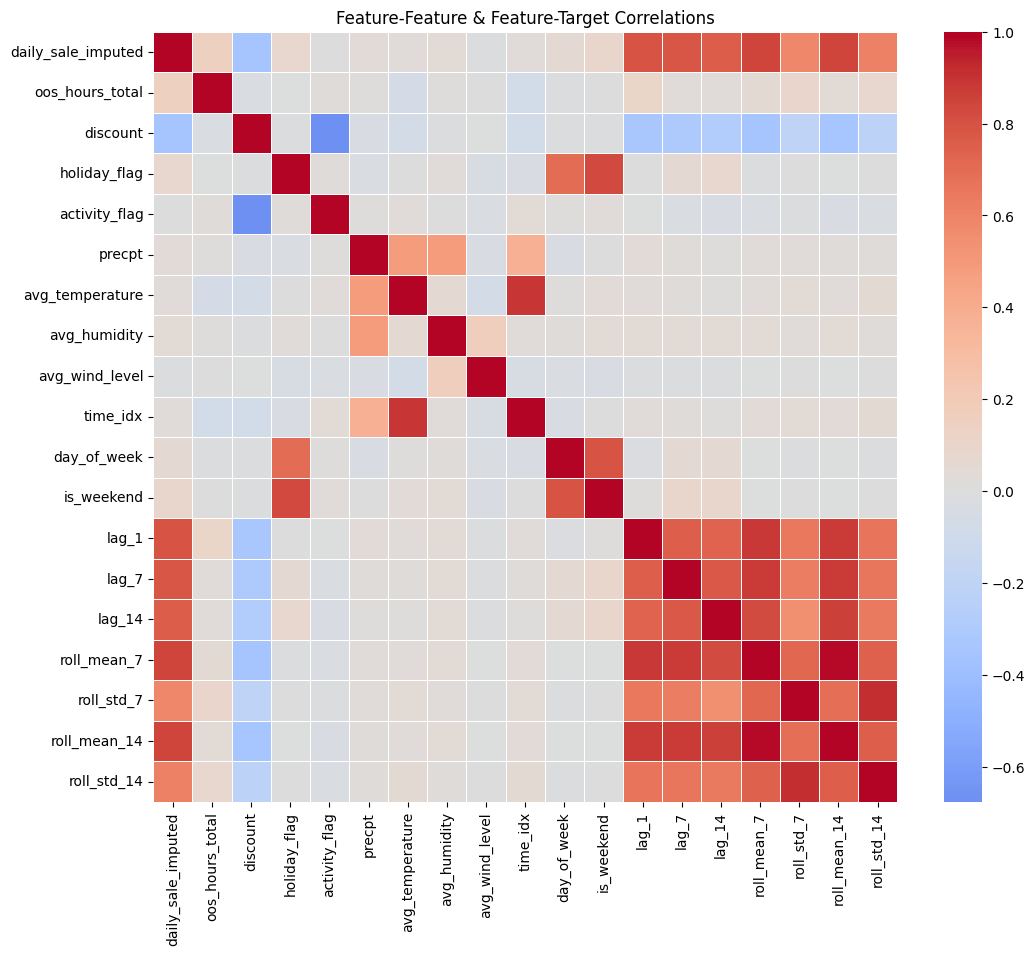

▶️ |daily_sale_imputed| correlations:
daily_sale_imputed    1.000000
roll_mean_14          0.846316
roll_mean_7           0.846211
lag_1                 0.793535
lag_7                 0.781793
lag_14                0.758031
roll_std_14           0.610915
roll_std_7            0.576540
discount              0.353973
oos_hours_total       0.153338
Name: daily_sale_imputed, dtype: float64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric features + the target
feature_cols = [
    "daily_sale_imputed",
    "oos_hours_total", "discount", "holiday_flag", "activity_flag",
    "precpt", "avg_temperature", "avg_humidity", "avg_wind_level",
    "time_idx", "day_of_week", "is_weekend",
    "lag_1", "lag_7", "lag_14",
    "roll_mean_7", "roll_std_7", "roll_mean_14", "roll_std_14"
]
corr = daily_df[feature_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr, 
    cmap="coolwarm", 
    center=0, 
    annot=False, 
    linewidths=0.5,
    xticklabels=corr.columns, 
    yticklabels=corr.columns
)
plt.title("Feature-Feature & Feature-Target Correlations")
plt.show()

# Print absolute correlations with target sorted
target_corr = corr["daily_sale_imputed"].abs().sort_values(ascending=False)
print("▶️ |daily_sale_imputed| correlations:")
print(target_corr.head(10))

In [6]:
# Define your final feature set
final_features = [
    # Target
    "daily_sale_imputed",
    # Temporal lags
    "lag_1", "lag_7", "lag_14",
    # Rolling
    "roll_mean_7",
    # Calendar/trend
    "day_of_week", "is_weekend", "time_idx",
    # Stockout flag
    "oos_hours_total",
    # (Optional) keep contextual if you like
    # "precpt", "avg_temperature", "avg_humidity", "avg_wind_level",
]

# Subset and drop any rows with NaNs in lag/rolling (first 14 days)
df_model = daily_df[final_features].dropna()

# Save for modeling
FINAL_FEATURE_PATH = "/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/notebooks/data/daily_dataset/daily_df_modelready.parquet"
df_model.to_parquet(FINAL_FEATURE_PATH, index=False)
print("✅ Model‐ready data saved:", df_model.shape)

✅ Model‐ready data saved: (3800000, 9)


In [3]:
FINAL_FEATURE_PATH = "/Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/notebooks/data/daily_dataset/daily_df_modelready.parquet"


✅ Saved feature–target correlations to: /Users/jhilmitasri/Repositories/MyRepositories/freshretail-demand-forecasting/notebooks/data/daily_dataset/corr_analysis


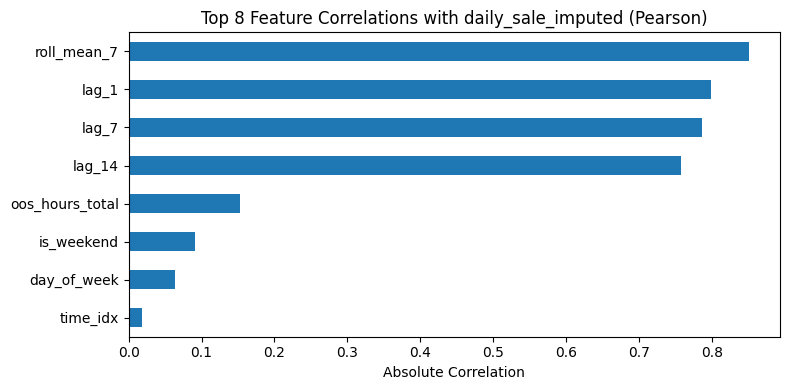

In [4]:
# --- Optional Extension: Feature–Target Correlation Analysis ---

import matplotlib.pyplot as plt
import os
# 1️⃣ Reload the model‐ready data (if not already in memory)
import pandas as pd
df_model = pd.read_parquet(FINAL_FEATURE_PATH)

# 2️⃣ Compute absolute Pearson & Spearman correlations with the target
pearson_corr  = df_model.corr()["daily_sale_imputed"].abs().sort_values(ascending=False)
spearman_corr = df_model.corr(method="spearman")["daily_sale_imputed"].abs().sort_values(ascending=False)

# 3️⃣ Save correlations to CSV for reference
corr_dir = os.path.join(os.path.dirname(FINAL_FEATURE_PATH), "corr_analysis")
os.makedirs(corr_dir, exist_ok=True)
pearson_corr.to_csv(os.path.join(corr_dir, "feature_target_corr_pearson.csv"))
spearman_corr.to_csv(os.path.join(corr_dir, "feature_target_corr_spearman.csv"))
print("✅ Saved feature–target correlations to:", corr_dir)

# 4️⃣ Plot top 8 Pearson correlations (excluding the target itself)
top_feats = pearson_corr.drop("daily_sale_imputed").head(8)
plt.figure(figsize=(8, 4))
top_feats.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 8 Feature Correlations with daily_sale_imputed (Pearson)")
plt.xlabel("Absolute Correlation")
plt.tight_layout()
plt.savefig(os.path.join(corr_dir, "top8_feature_target_corr.png"), dpi=200)
plt.show()

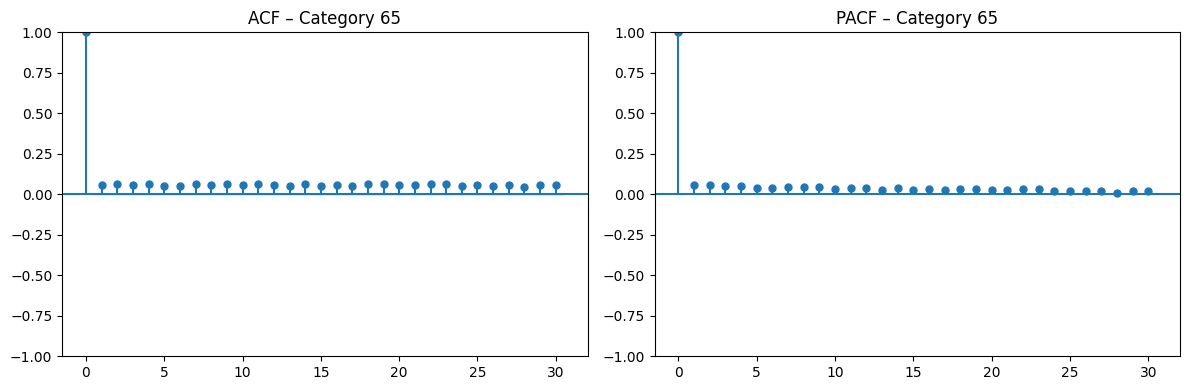

In [17]:
# --- Optional ACF & PACF Analysis on a Representative Series ---

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1️⃣ Load the full daily dataset (with IDs and dates)
DAILY_FULL_PATH = "data/daily_dataset/daily_df_imputed.parquet"
daily_full = pd.read_parquet(DAILY_FULL_PATH)
daily_full["dt"] = pd.to_datetime(daily_full["dt"])

# 2️⃣ Select one series to inspect (e.g. first third_category_id)
cat_id = daily_full["third_category_id"].unique()[0]
series = (
    daily_full
    .loc[daily_full["third_category_id"] == cat_id, ["dt","daily_sale_imputed"]]
    .sort_values("dt")
    .set_index("dt")["daily_sale_imputed"]
)

# 3️⃣ Plot ACF & PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series,  lags=30, ax=axes[0]); axes[0].set_title(f"ACF – Category {cat_id}")
plot_pacf(series, lags=30, ax=axes[1]); axes[1].set_title(f"PACF – Category {cat_id}")
plt.tight_layout()
plt.show()

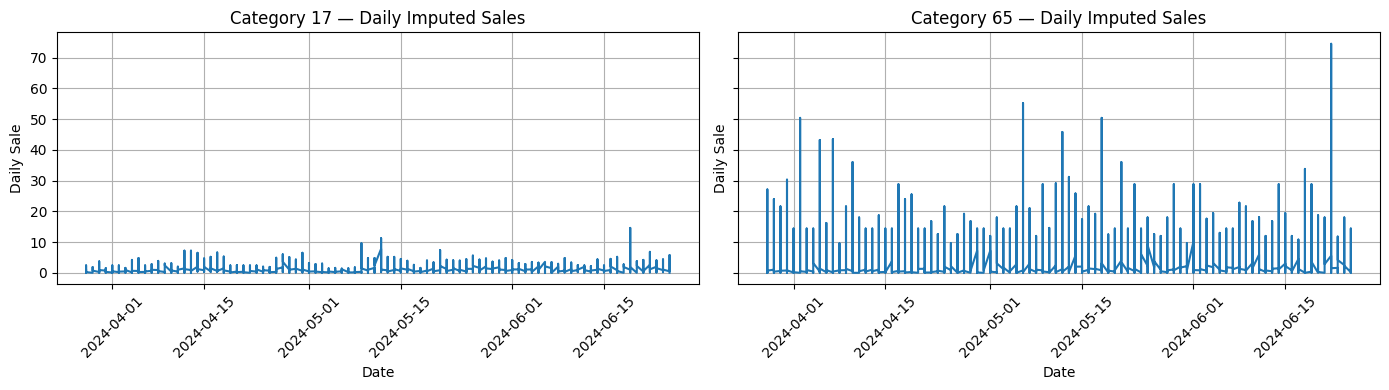

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load the daily data
DAILY_PATH = "data/daily_dataset/daily_df_imputed.parquet"
df = pd.read_parquet(DAILY_PATH)
df["dt"] = pd.to_datetime(df["dt"])

# 2️⃣ Pick your categories
cats = [17, 65]
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

for ax, cat_id in zip(axes, cats):
    series = (
        df[df["third_category_id"] == cat_id]
        .sort_values("dt")
    )
    ax.plot(series["dt"], series["daily_sale_imputed"], linestyle="-")
    ax.set_title(f"Category {cat_id} — Daily Imputed Sales")
    ax.set_xlabel("Date")
    ax.set_ylabel("Daily Sale")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()